In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot, scatter, plot, axis
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# Datetime
import datetime as dt
from datetime import datetime
from datetime import timedelta

import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
Industry_Portfolio=pd.read_excel("Industry_Portfolios.xlsx",index_col=0)

In [4]:
Market_Portfolio=pd.read_excel("Market_Portfolio.xlsx",index_col=0)

In [5]:
Risk_Factors=pd.read_excel("Risk_Factors.xlsx",index_col=0)

In [6]:
for i in Industry_Portfolio.columns:
    Industry_Portfolio[str(i)] = Industry_Portfolio[i].subtract(Risk_Factors["Rf"], fill_value=0)

In [7]:
Merged_Portfolio = Industry_Portfolio.merge(Risk_Factors,how='inner',left_index=True, right_index=True)

In [8]:
# Initialize the Market_model DataFrame with appropriate indices and columns
Market_model=pd.DataFrame(index=["Jensen Alpha","CAPM beta"],columns=Industry_Portfolio.columns)

# Loop through the first 10 columns of Merged_Portfolio (industry portfolios)
for column in range(Market_model.shape[1]):
    y = Merged_Portfolio.iloc[:, column]           # Dependent variable (industry portfolio)
    x = Merged_Portfolio[["Rm-Rf"]]                # Independent variables (Market)
    
    # Add a constant (intercept term) to the independent variables
    x = sm.add_constant(x)
    
    # Perform linear regression
    model = sm.OLS(y, x).fit()

    # Store the regression results in the Market_model DataFrame
    Market_model.iloc[0, column] = model.params['const']  # Intercept
    Market_model.iloc[1, column] = model.params['Rm-Rf']  # Market (Rm-Rf)

In [9]:
# Initialize the Fama_French_model DataFrame with appropriate indices and columns
Fama_French_model=pd.DataFrame(index=["Intercept","Market","SMB","HML"],columns=Industry_Portfolio.columns)

# Loop through the first 10 columns of Merged_Portfolio (industry portfolios)
for column in range(Fama_French_model.shape[1]):
    y = Merged_Portfolio.iloc[:, column]           # Dependent variable (industry portfolio)
    x = Merged_Portfolio[["Rm-Rf", "SMB", "HML"]]  # Independent variables (Market, SMB, HML)
    
    # Add a constant (intercept term) to the independent variables
    x = sm.add_constant(x)
    
    # Perform linear regression
    model = sm.OLS(y, x).fit()

    # Store the regression results in the Fama_French_model DataFrame
    Fama_French_model.iloc[0, column] = model.params['const']  # Intercept
    Fama_French_model.iloc[1, column] = model.params['Rm-Rf']  # Market (Rm-Rf)
    Fama_French_model.iloc[2, column] = model.params['SMB']    # SMB
    Fama_French_model.iloc[3, column] = model.params['HML']    # HML

In [10]:
Fama_French_model.T

,Intercept,Market,SMB,HML
NoDur,0.386704,0.712134,-0.229102,-0.023342
Durbl,-0.474342,1.447452,0.670878,0.240949
Manuf,0.153285,1.142282,0.087388,0.027727
Enrgy,0.523007,1.028354,-0.25936,-0.008158
HiTec,-0.065979,1.152803,0.335674,-0.556947
Telcm,0.200724,0.924137,-0.080299,-0.019063
Shops,0.255941,0.770227,0.280191,-0.03908
Hlth,0.257472,0.751976,-0.212655,-0.143765
Utils,0.474411,0.631827,-0.387961,-0.016881
Other,-0.404412,1.123473,-0.061676,0.547325


In [11]:
Sharpe_df=pd.DataFrame(index=["Sharpe"],columns=Industry_Portfolio.columns)

for column in range(Sharpe_df.shape[1]):
    Risk_Premium = Industry_Portfolio.iloc[:, column].mean()          
    Standard_Deviation = Industry_Portfolio.iloc[:, column].std() 
    Sharpe_ratio=Risk_Premium/Standard_Deviation
    Sharpe_df.iloc[0,column]=Sharpe_ratio
    
# Note: If Information ratio target is rf then it is the same as Sharpe ratio

In [12]:
Sortino_df=pd.DataFrame(index=["Sortino"],columns=Industry_Portfolio.columns)

for column in range(Sortino_df.shape[1]):
    # Calculate Risk Premium (mean return)
    Risk_Premium = Industry_Portfolio.iloc[:, column].mean() 
    
    # Calculate downside risk
    Returns = Industry_Portfolio.iloc[:, column]  # Extract the returns for the column
    downside_risk = np.where(Returns < 0, Returns ** 2, 0)  # Squared negative returns
    
    # Calculate Negative Standard Deviation (downside risk)
    Negative_Standard_Deviation = np.sqrt(np.mean(downside_risk))
    
    # Calculate Sortino Ratio
    if Negative_Standard_Deviation != 0:
        Sortino_ratio = Risk_Premium / Negative_Standard_Deviation     
    else:
        Sortino_ratio = None
    
    Sortino_df.iloc[0,column]=Sortino_ratio

In [13]:
Treynor_df=pd.DataFrame(index=["Treynor"],columns=Industry_Portfolio.columns)

for column in range(Treynor_df.shape[1]):
    column_name=Treynor_df.columns[column]
    Risk_Premium = Industry_Portfolio.iloc[:, column].mean()          
    Beta=Market_model.loc["CAPM beta",column_name]
    Treynor_ratio=Risk_Premium/Beta
    Treynor_df.iloc[0,column]=Treynor_ratio

In [14]:
Jensen_Alpha_df=pd.DataFrame(index=["Jensen_Alpha"],columns=Industry_Portfolio.columns)
Jensen_Alpha_df.iloc[0,:]=Market_model.loc["Jensen Alpha",:]

In [15]:
Fama_French_Alpha_df=pd.DataFrame(index=["Fama_French_Alpha"],columns=Industry_Portfolio.columns)
Fama_French_Alpha_df.iloc[0,:]=Fama_French_model.loc["Intercept",:]

In [16]:
Performance_Measures=pd.concat([Sharpe_df,Sortino_df,Treynor_df,Jensen_Alpha_df,Fama_French_Alpha_df])
Performance_Measures=Performance_Measures.T

In [17]:
Performance_Measures

,Sharpe,Sortino,Treynor,Jensen_Alpha,Fama_French_Alpha
NoDur,0.231099,0.350804,1.186372,0.369717,0.386704
Durbl,0.072356,0.111967,0.367463,-0.417903,-0.474342
Manuf,0.166616,0.24126,0.758251,0.160494,0.153285
Enrgy,0.181708,0.273612,1.14333,0.504485,0.523007
HiTec,0.118552,0.17062,0.564295,-0.064024,-0.065979
Telcm,0.169064,0.24494,0.836363,0.194348,0.200724
Shops,0.191753,0.293032,0.951258,0.274093,0.255941
Hlth,0.172529,0.270294,0.971435,0.236968,0.257472
Utils,0.210948,0.290044,1.452334,0.446523,0.474411
Other,0.064693,0.087351,0.299781,-0.387508,-0.404412


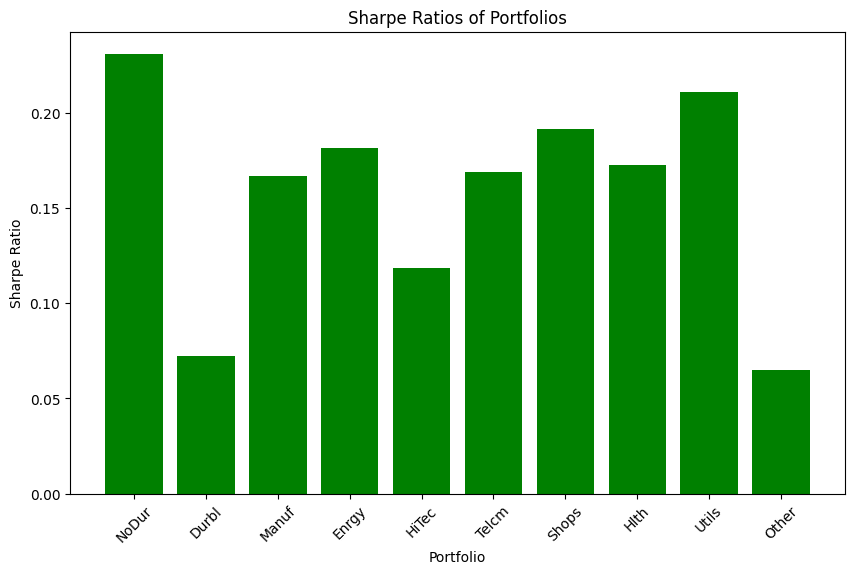

In [18]:
# Create a bar chart for the Sharpe ratios of each portfolio
plt.figure(figsize=(10,6))  
plt.bar(Performance_Measures.index, Performance_Measures["Sharpe"], color='green')

plt.title("Sharpe Ratios of Portfolios")
plt.xlabel("Portfolio")
plt.ylabel("Sharpe Ratio")

plt.xticks(rotation=45)  
plt.show()

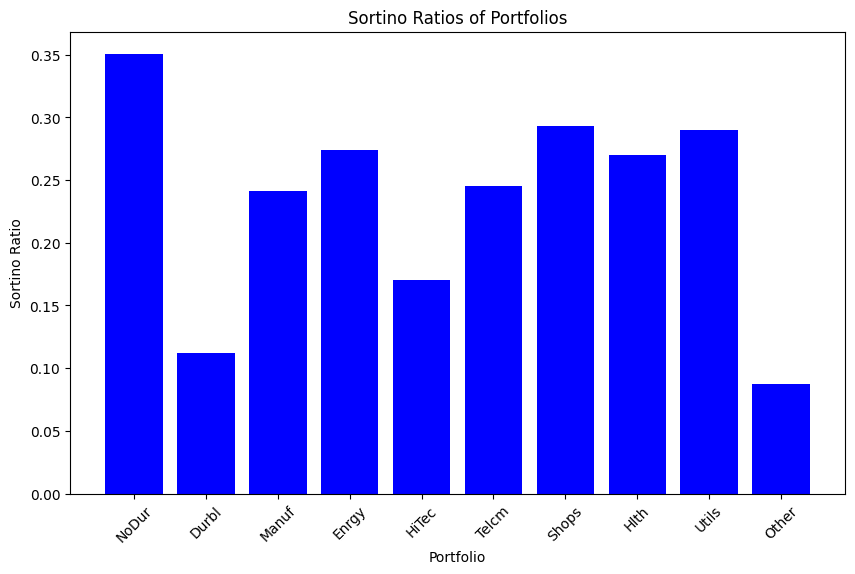

In [19]:
# Create a bar chart for the Sortino ratios of each portfolio
plt.figure(figsize=(10,6))  
plt.bar(Performance_Measures.index, Performance_Measures["Sortino"], color='blue')

plt.title("Sortino Ratios of Portfolios")
plt.xlabel("Portfolio")
plt.ylabel("Sortino Ratio")

plt.xticks(rotation=45)  
plt.show()

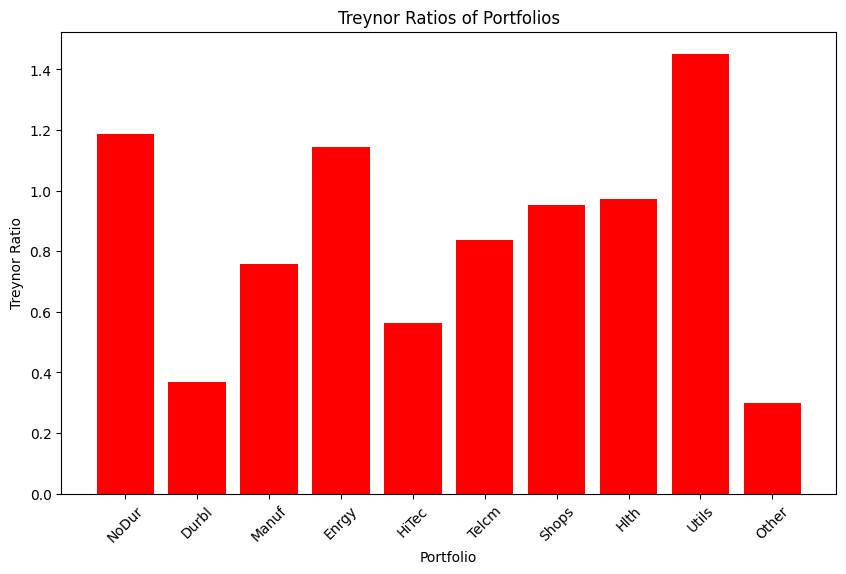

In [20]:
# Create a bar chart for the Treynor ratios of each portfolio
plt.figure(figsize=(10,6))  
plt.bar(Performance_Measures.index, Performance_Measures["Treynor"], color='red')

plt.title("Treynor Ratios of Portfolios")
plt.xlabel("Portfolio")
plt.ylabel("Treynor Ratio")

plt.xticks(rotation=45)  
plt.show()

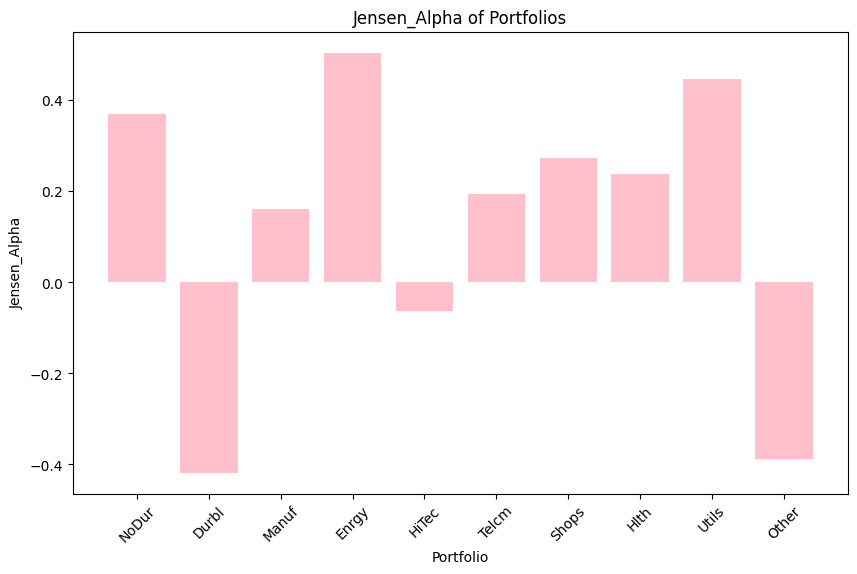

In [21]:
# Create a bar chart for the Jensen_Alpha of each portfolio
plt.figure(figsize=(10,6))  
plt.bar(Performance_Measures.index, Performance_Measures["Jensen_Alpha"], color='pink')

plt.title("Jensen_Alpha of Portfolios")
plt.xlabel("Portfolio")
plt.ylabel("Jensen_Alpha")

plt.xticks(rotation=45)  
plt.show()

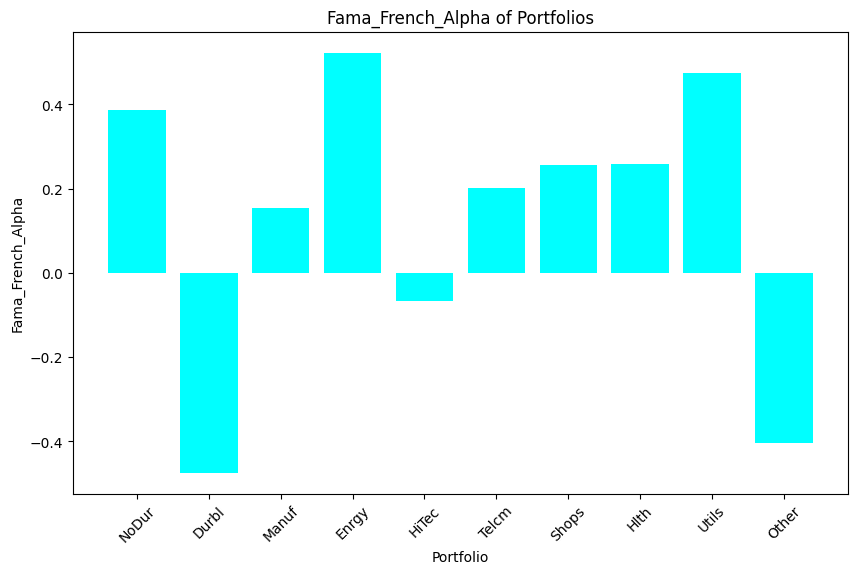

In [22]:
# Create a bar chart for the Fama_French_Alpha of each portfolio
plt.figure(figsize=(10,6))  
plt.bar(Performance_Measures.index, Performance_Measures["Fama_French_Alpha"], color='cyan')

plt.title("Fama_French_Alpha of Portfolios")
plt.xlabel("Portfolio")
plt.ylabel("Fama_French_Alpha")

plt.xticks(rotation=45)  
plt.show()

#### Economic significance and pricing implications of each of the three performance ratios 

The Sharpe ratio measures the risk premium per unit of standard deviation. Standard deviation captures total risk (both systematic and idiosyncatic risk), therefore Sharpe ratio is more appropriate for comparing well diversified portfolio with low/no idiosyncratic risk and less appropriate for comparing between individual investments and diversified portfolios. A drawback of using standard deviation as a measure of risk is that it assumes that returns are normally distributed, and thus is unable to distinguish between asymetric return distributions with the same variance but different skewness. When comparing 2 well-diversified portfolios, the portfolio with higher Sharpe ratio provides higher returns for every unit of volatility and is thus a more attractive portfolio.

Treynor ratio measures the risk premium per unit of market risk (beta). As beta only includes systematic (market) risk and ignores idiosyncratic risk, Treynor ratio can be used to compare the performance of individual investment to diversified portfolio. However, it does not take into account other types of systematic risk such as size or value, only considering market risk. A portfolio with higher Treynor ratio provides better risk premium for its exposure to market risk compared with a portfolio with lower Treynor ratio. All portfolios on the SML should have the same Treynor ratio.

Sortino ratio measures the portfolio's expected deviation from the benchmark return, per unit of below-target semi-deviation. Below-target semi-deviation only considers risk that realised return on investment falls below the target return. As below-target semi-variance is a measure of downside risk, Sortino ratio is able to distinguish between asymmetric distributions with same variance but different skewness. As investors are more sensitive to downside volatility compared with upside volatility, Sortino ratio maybe more informative compared to the Sharpe ratio, especially when the return distribution is not normal. Returns with the same variance but different skewness would have the same Sharpe Ratio but different Sortino ratio.